This notebook is for applying the version of inter slice with evaluation of beta to higher resolution datasets

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/home/federico/Università/Tesi_magistrale/my_programs/')

from contact_matrix_utils import *
import settings
from src.slice_pairwise import *
from src.interchromosomal_cosegregation import *
from src.slice_pairwise_inter_beta_evaluation import *
from numpy.random import Generator, MT19937
from scipy.stats import pearsonr, spearmanr

In [2]:
def chromosome_bin_lenght(segregation_table, chrom):
    return np.ceil(segregation_table[chrom]['stop_position'][-1]/resolution).astype(int)

In [3]:
which_beta = "$\\beta$ evaluated "

In [4]:
def select_chromosomes_coordinates(chrA, chrB, chr_windows_sizes):
    if(chrA==0 or chrB ==0):
        print("0 is not accepted as chromosome index ")
        return

    chrA_idx, chrB_idx = chrA - 1, chrB - 1

    if(chrA_idx>chrB_idx):
        chrA_idx, chrB_idx = chrB_idx, chrA_idx

    start_row    = np.sum(chr_windows_sizes[:chrA_idx])
    stop_row     = start_row + chr_windows_sizes[chrA_idx]
    start_column = np.sum(chr_windows_sizes[:chrB_idx])
    stop_column  = start_column + chr_windows_sizes[chrB_idx]

    return start_row, stop_row, start_column, stop_column

# $\pi$ genomewide matrix import #

In [5]:
name_root_3NP_150kb_dopa = "dopa30_150kb_482x3"

path_1 =      r"/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/" + name_root_3NP_150kb_dopa + "/"
file_name_1 = "segregation_" + name_root_3NP_150kb_dopa +  ".pkl"
with open(path_1 + file_name_1, 'rb') as f:
    segregation_table_3NP_150kb_dopa = pickle.load(f)

In [6]:
name_root_mesc_3NP_150kb = "iza-mesc_150kb_420x3"

path_1 =      r"/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/" + name_root_mesc_3NP_150kb + "/"
file_name_1 = "segregation_" + name_root_mesc_3NP_150kb +  ".pkl"
with open(path_1 + file_name_1, 'rb') as f:
    segregation_table_mesc_3NP_150kb = pickle.load(f)

In [7]:
start_chr, stop_chr = 1, 19
stop_chr += 1
chromosomes = []
n_chromosomes = stop_chr - start_chr

l = []
size_1Mb = 0

for i in range(start_chr, stop_chr):
    chrA = 'chr' + str(i)
    chromosomes += [chrA]
    s = segregation_table_3NP_150kb_dopa[chrA]['segregation_table'].shape[0]
    size_1Mb += s
    l.append(s) 

chr_windows_sizes_1Mb = np.array(l)

l = []
size_150kb = 0

for i in range(start_chr, stop_chr):
    chrA = 'chr' + str(i)
    chromosomes += [chrA]
    s = segregation_table_mesc_3NP_150kb[chrA]['segregation_table'].shape[0]
    size_150kb += s
    l.append(s) 

chr_windows_sizes_150kb = np.array(l)

del l


In [8]:
gw_PI_3NP_150kb_dopa = np.zeros((size_1Mb, size_1Mb))
gw_PI_95_significant_3NP_150kb_dopa = np.zeros((size_1Mb, size_1Mb))

for i in range(n_chromosomes):
    for j in range(i, n_chromosomes):
        start_row    = np.sum(chr_windows_sizes_1Mb[:i])
        stop_row     = start_row + chr_windows_sizes_1Mb[i]
        start_column = np.sum(chr_windows_sizes_1Mb[:j])
        stop_column  = start_column + chr_windows_sizes_1Mb[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]
        if(chrA!=chrB):
            gw_PI_3NP_150kb_dopa[start_row:stop_row, start_column:stop_column] = np.load(data_path + name_root_3NP_150kb_dopa + "/PI2_inter_beta_evaluation/" + "PI2_inter_" +  chrA + "_" + chrB + "_" + name_root_3NP_150kb_dopa + ".npy")
            gw_PI_95_significant_3NP_150kb_dopa[start_row:stop_row, start_column:stop_column] = np.load(data_path + name_root_3NP_150kb_dopa + "/PI2_inter_beta_evaluation/" + "PI2_inter_significant_95_" +  chrA + "_" + chrB + "_" + name_root_3NP_150kb_dopa + ".npy")
        else:
            gw_PI_3NP_150kb_dopa[start_row:stop_row, start_column:stop_column] = squareform(np.loadtxt(data_path + name_root_3NP_150kb_dopa + "/PI2/" + "PI2_" + chrA + "_" + name_root_3NP_150kb_dopa + ".txt") )
            gw_PI_95_significant_3NP_150kb_dopa[start_row:stop_row, start_column:stop_column] = squareform(np.loadtxt(data_path + name_root_3NP_150kb_dopa + "/PI2/" + "PI2_significant_95_" + chrA + "_" + name_root_3NP_150kb_dopa + ".txt") )

# for i in range(gw_PI_3NP_150kb_dopa.shape[0]):
#     for j in range(gw_PI_3NP_150kb_dopa.shape[1]):
#         gw_PI_3NP_150kb_dopa[j,i] = gw_PI_3NP_150kb_dopa[i,j]
#         gw_PI_95_significant_3NP_150kb_dopa[j,i] = gw_PI_95_significant_3NP_150kb_dopa[i, j] 

In [9]:
gw_PI_mesc_3NP_150kb = np.zeros((size_150kb, size_150kb))
gw_PI_95_significant_mesc_3NP_150kb = np.zeros((size_150kb, size_150kb))

for i in tqdm(range(n_chromosomes), leave = False):
    for j in range(i, n_chromosomes):
        start_row    = np.sum(chr_windows_sizes_150kb[:i])
        stop_row     = start_row + chr_windows_sizes_150kb[i]
        start_column = np.sum(chr_windows_sizes_150kb[:j])
        stop_column  = start_column + chr_windows_sizes_150kb[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]
        if(chrA!=chrB):
            gw_PI_mesc_3NP_150kb[start_row:stop_row, start_column:stop_column] = np.load(data_path + name_root_mesc_3NP_150kb + "/PI2_inter_beta_evaluation/" + "PI2_inter_" +  chrA + "_" + chrB + "_" + name_root_mesc_3NP_150kb + ".npy")
            gw_PI_95_significant_mesc_3NP_150kb[start_row:stop_row, start_column:stop_column] = np.load(data_path + name_root_mesc_3NP_150kb + "/PI2_inter_beta_evaluation/" + "PI2_inter_significant_95_" +  chrA + "_" + chrB + "_" + name_root_mesc_3NP_150kb + ".npy")
        else:
            gw_PI_mesc_3NP_150kb[start_row:stop_row, start_column:stop_column] = squareform(np.loadtxt(data_path + name_root_mesc_3NP_150kb + "/PI2/" + "PI2_" + chrA + "_" + name_root_mesc_3NP_150kb + ".txt") )
            gw_PI_95_significant_mesc_3NP_150kb[start_row:stop_row, start_column:stop_column] = squareform(np.loadtxt(data_path + name_root_mesc_3NP_150kb + "/PI2/" + "PI2_significant_95_" + chrA + "_" + name_root_mesc_3NP_150kb + ".txt") )

#for i in range(gw_PI_mesc_3NP_150kb.shape[0]):
#    for j in range(gw_PI_mesc_3NP_150kb.shape[1]):
#        gw_PI_mesc_3NP_150kb[j,i] = gw_PI_mesc_3NP_150kb[i,j]
#        gw_PI_95_significant_mesc_3NP_150kb[j,i] = gw_PI_95_significant_mesc_3NP_150kb[i, j] 

# Mean $\pi$ per chromosome couple 3NP 1Mb #

In [10]:
PI_means_3NP_150kb_dopa = np.zeros((19,19))
PI_significant_means_3NP_150kb_dopa   = np.zeros((19,19))

In [11]:
for i in range(n_chromosomes):
    for j in range(i,n_chromosomes):
        start_row    = np.sum(chr_windows_sizes_1Mb[:i])
        stop_row     = start_row + chr_windows_sizes_1Mb[i]
        start_column = np.sum(chr_windows_sizes_1Mb[:j])
        stop_column  = start_column + chr_windows_sizes_1Mb[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]
        
        temp_1 = np.copy(gw_PI_3NP_150kb_dopa[start_row:stop_row, start_column:stop_column])
        temp_1[temp_1== 0] = np.nan
        temp_2 = np.copy(gw_PI_95_significant_3NP_150kb_dopa[start_row:stop_row, start_column:stop_column])
        temp_2[temp_2== 0] = np.nan
        


        PI_means_3NP_150kb_dopa[i, j] = np.nanmean( temp_1  )
        PI_significant_means_3NP_150kb_dopa[i, j]   = np.nanmean( temp_2  )

        PI_means_3NP_150kb_dopa[j, i]= PI_means_3NP_150kb_dopa[i, j]
        PI_significant_means_3NP_150kb_dopa[j, i]    =  PI_significant_means_3NP_150kb_dopa[i, j]
del temp_1, temp_2

PI_means_3NP_150kb_dopa = np.nan_to_num(PI_means_3NP_150kb_dopa, 0)
PI_significant_means_3NP_150kb_dopa = np.nan_to_num(PI_significant_means_3NP_150kb_dopa, 0)

/home/federico/Università/Tesi_magistrale/my_programs/contact_matrix_utils.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals]);


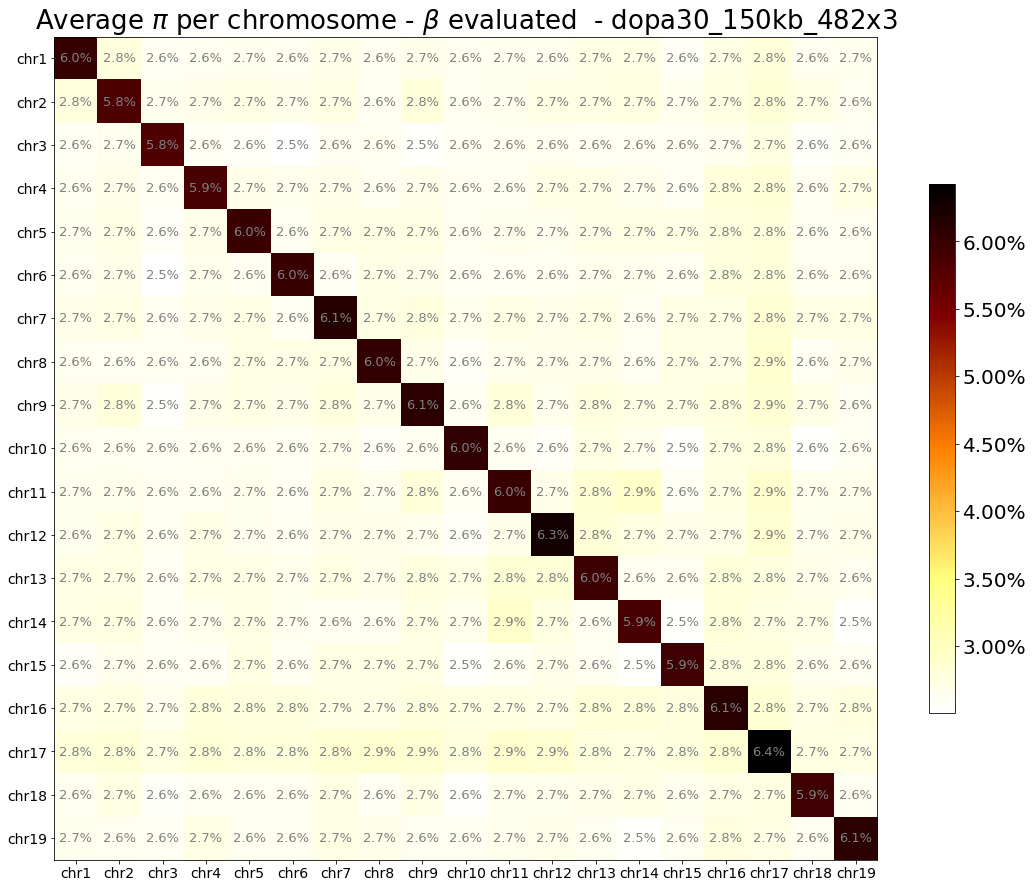

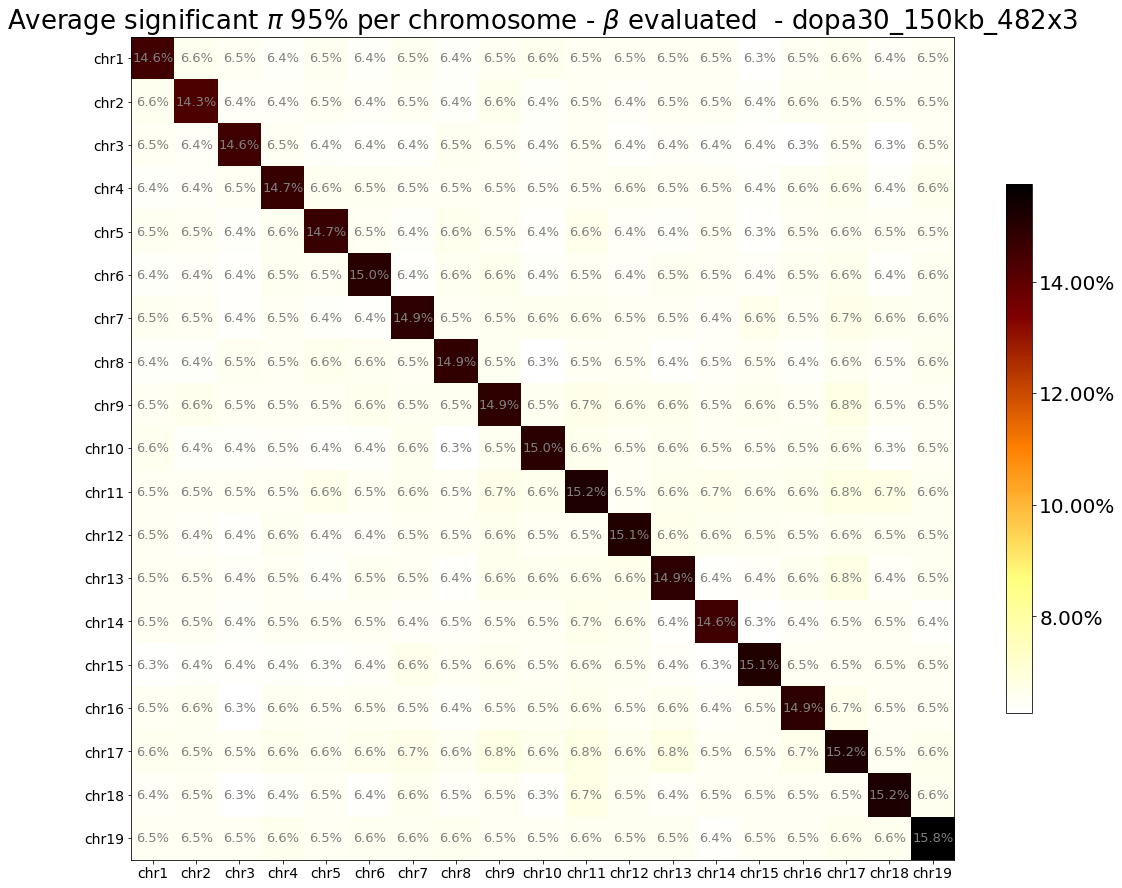

In [12]:
fig, ax, c = plot_heatmap(PI_means_3NP_150kb_dopa, x_figsize= 15, y_figsize= 15, percent=True)

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, str(np.around(PI_means_3NP_150kb_dopa[i, j]*100, decimals=1)) + "%",
                       ha="center", va="center", color="grey", fontsize = 13)

ax.set_title("Average $\pi$ per chromosome - " + which_beta + " - " + name_root_3NP_150kb_dopa, fontsize = 26)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
c.ax.tick_params(axis='y', which='major', labelsize=20)


fig, ax, c = plot_heatmap(PI_significant_means_3NP_150kb_dopa, x_figsize= 15, y_figsize= 15, percent=True)

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, str(np.around(PI_significant_means_3NP_150kb_dopa[i, j]*100, decimals=1)) + "%",
                       ha="center", va="center", color="grey", fontsize = 13)

ax.set_title("Average significant $\pi$ 95% per chromosome - " + which_beta + " - " + name_root_3NP_150kb_dopa, fontsize = 26)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
c.ax.tick_params(axis='y', which='major', labelsize=20)

del fig, ax, c, text


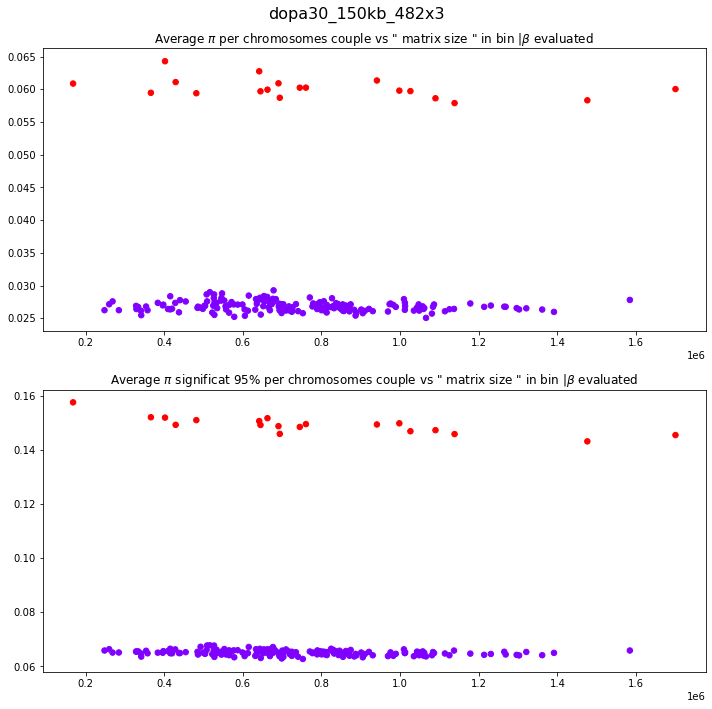

In [13]:
fig, ax = plt.subplots(nrows=2, figsize = (10,10))

x_1 = []
y_1 = []
y_2 = []
diagonal_labels = []


for i in range(19):
    for j in range(i, 19):
        
            x_1.append(chr_windows_sizes_1Mb[i] * chr_windows_sizes_1Mb[j])
            y_1.append(PI_means_3NP_150kb_dopa[i,j])
            y_2.append(PI_significant_means_3NP_150kb_dopa[i,j])

            if(i == j):
                diagonal_labels.append(1)
            else:
                diagonal_labels.append(0)




chr_interaction_vs_lenght = pd.DataFrame(data = np.array([x_1, y_1, y_2, diagonal_labels]).T, columns=['x', 'y1', 'y2', 'colour'] )
chr_interaction_vs_lenght.sort_values(by = ['x'], inplace=True)


ax[0].scatter(chr_interaction_vs_lenght.values[:, 0], chr_interaction_vs_lenght.values[:, 1], s = 30, c = chr_interaction_vs_lenght.values[:, -1], cmap = 'rainbow')
ax[1].scatter(chr_interaction_vs_lenght.values[:, 0], chr_interaction_vs_lenght.values[:, 2], s = 30, c = chr_interaction_vs_lenght.values[:, -1], cmap = 'rainbow')

ax[0].set_title("Average $\pi$ per chromosomes couple vs \" matrix size \" in bin |" + which_beta)
ax[1].set_title("Average $\pi$ significat 95% per chromosomes couple vs \" matrix size \" in bin |" + which_beta)

#ax[1].set_ylim([0.1,0.12])

fig.suptitle(name_root_3NP_150kb_dopa, fontsize=16)

fig.tight_layout()

del fig, ax, x_1, y_1, y_2, diagonal_labels, chr_interaction_vs_lenght 


# Mean $\pi$ per chromosome couple 3NP 150kb #

In [14]:
PI_means_mesc_3NP_150kb = np.zeros((19,19))
PI_significant_means_mesc_3NP_150kb   = np.zeros((19,19))

In [15]:
for i in range(n_chromosomes):
    for j in range(i,n_chromosomes):
        start_row    = np.sum(chr_windows_sizes_150kb[:i])
        stop_row     = start_row + chr_windows_sizes_150kb[i]
        start_column = np.sum(chr_windows_sizes_150kb[:j])
        stop_column  = start_column + chr_windows_sizes_150kb[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]
        

        temp_1 = np.copy(gw_PI_mesc_3NP_150kb[start_row:stop_row, start_column:stop_column])
        temp_1[temp_1== 0] = np.nan
        temp_2 = np.copy(gw_PI_95_significant_mesc_3NP_150kb[start_row:stop_row, start_column:stop_column])
        temp_2[temp_2== 0] = np.nan
        


        PI_means_mesc_3NP_150kb[i, j] = np.nanmean( temp_1  )
        PI_significant_means_mesc_3NP_150kb[i, j]   = np.nanmean( temp_2  )

        PI_means_mesc_3NP_150kb[j, i]= PI_means_mesc_3NP_150kb[i, j]
        PI_significant_means_mesc_3NP_150kb[j, i]    =  PI_significant_means_mesc_3NP_150kb[i, j]

del temp_1, temp_2

PI_means_mesc_3NP_150kb = np.nan_to_num(PI_means_mesc_3NP_150kb, 0)
PI_significant_means_mesc_3NP_150kb = np.nan_to_num(PI_significant_means_mesc_3NP_150kb, 0)

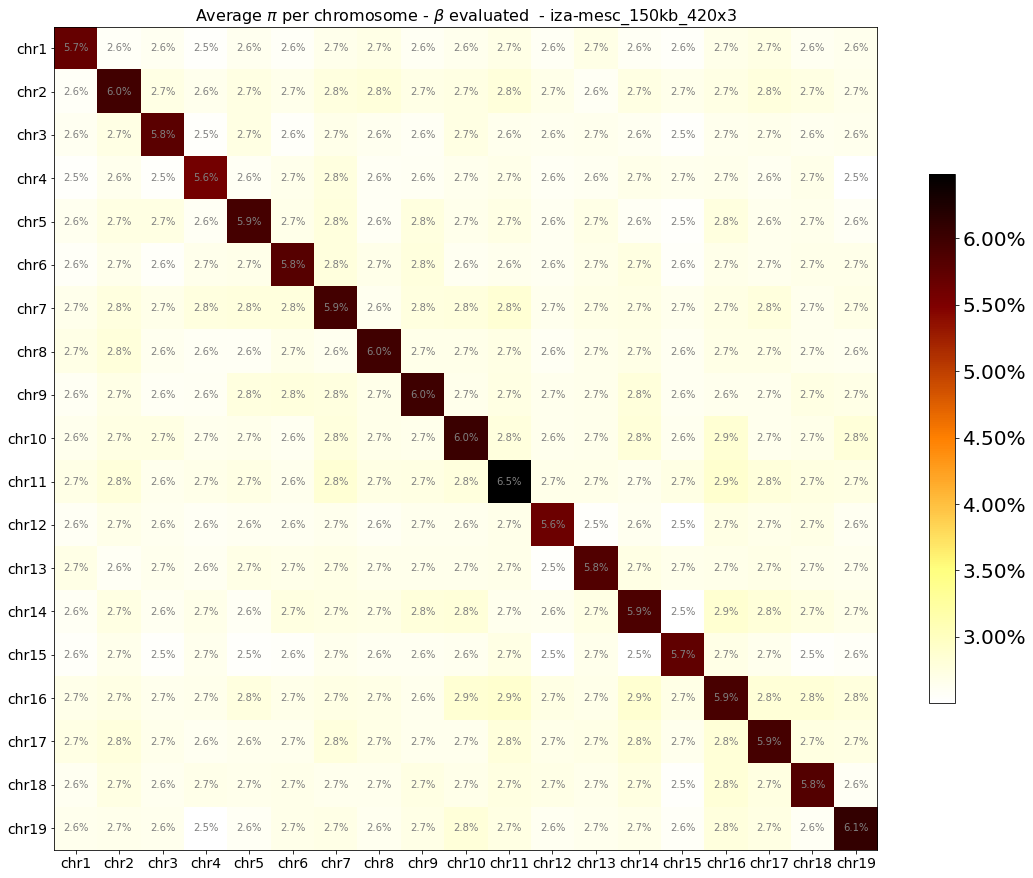

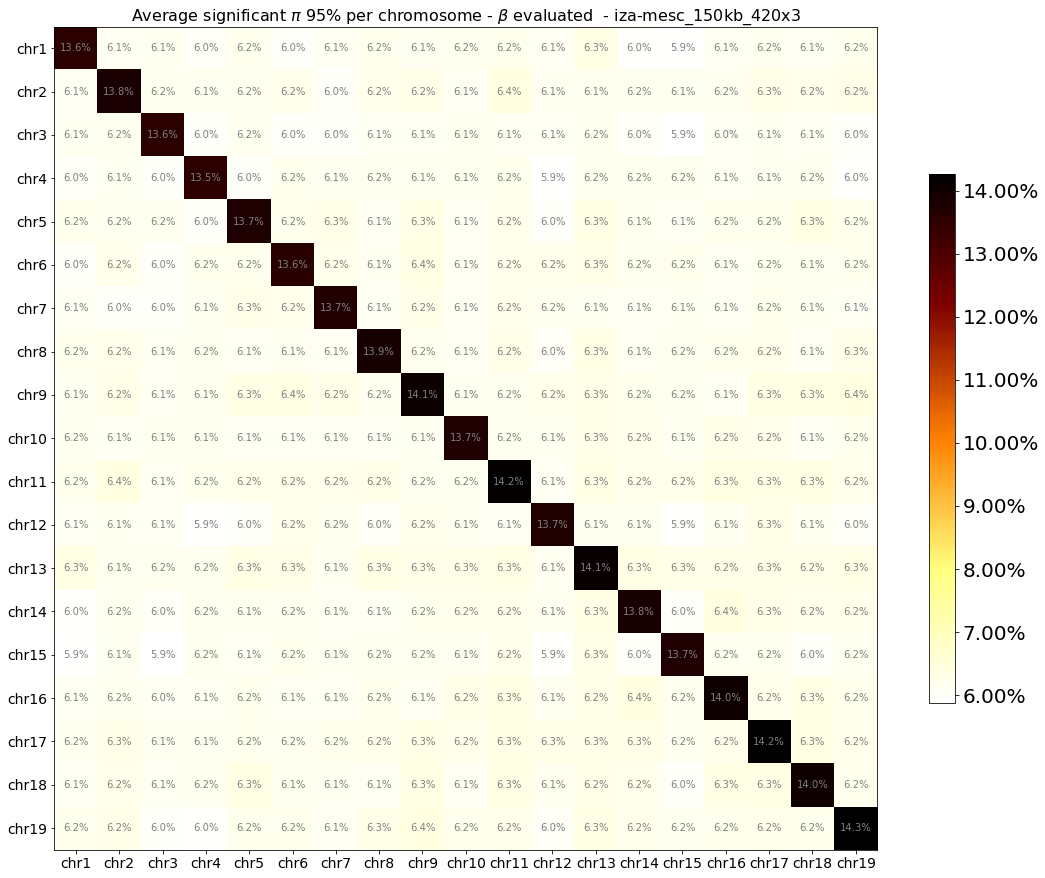

In [16]:
fig, ax, c = plot_heatmap(PI_means_mesc_3NP_150kb, x_figsize= 15, y_figsize= 15, percent=True)

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, str(np.around(PI_means_mesc_3NP_150kb[i, j]*100, decimals=1)) + "%",
                       ha="center", va="center", color="grey")

ax.set_title("Average $\pi$ per chromosome - " + which_beta + " - " + name_root_mesc_3NP_150kb, fontsize = 16)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
c.ax.tick_params(axis='y', which='major', labelsize=20)


fig, ax, c = plot_heatmap(PI_significant_means_mesc_3NP_150kb, x_figsize= 15, y_figsize= 15, percent=True)

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, str(np.around(PI_significant_means_mesc_3NP_150kb[i, j]*100, decimals=1)) + "%",
                       ha="center", va="center", color="grey")

ax.set_title("Average significant $\pi$ 95% per chromosome - " + which_beta + " - " + name_root_mesc_3NP_150kb, fontsize = 16)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'], fontsize = 14);
c.ax.tick_params(axis='y', which='major', labelsize=20)

del fig, ax, c, text


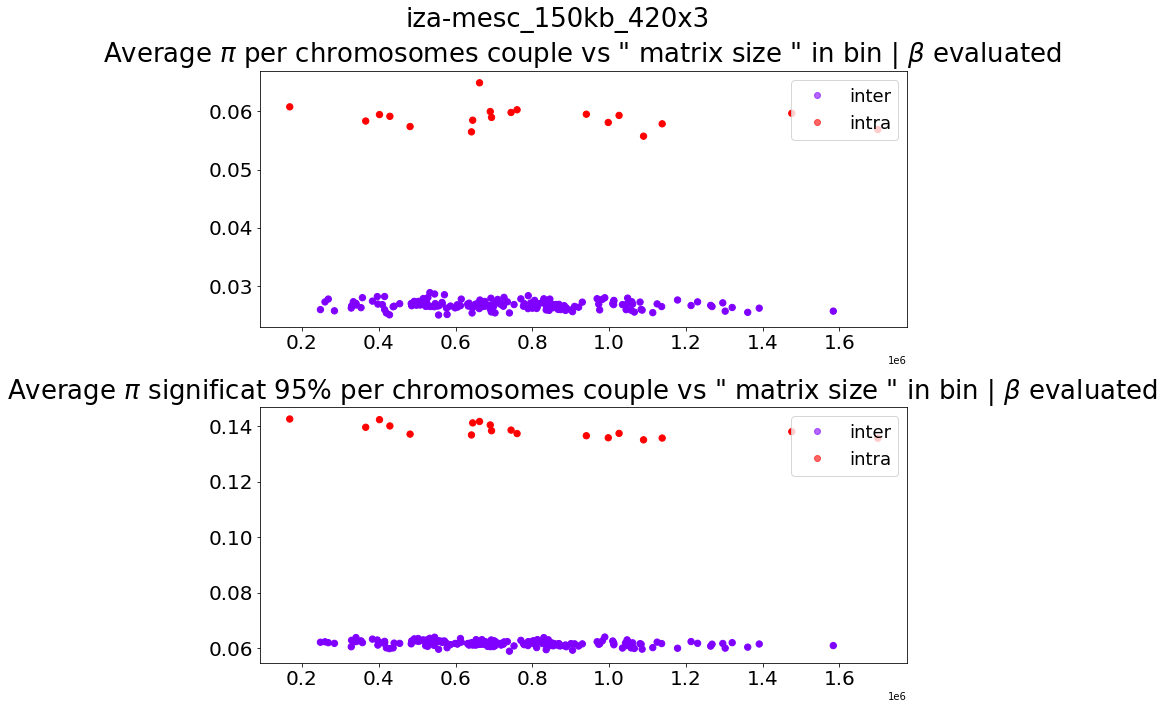

In [17]:
fig, ax = plt.subplots(nrows=2, figsize = (10,10))

x_1 = []
y_1 = []
y_2 = []
diagonal_labels = []

for i in range(19):
    for j in range(i, 19):
        
            x_1.append(chr_windows_sizes_1Mb[i] * chr_windows_sizes_1Mb[j])
            y_1.append(PI_means_mesc_3NP_150kb[i,j])
            y_2.append(PI_significant_means_mesc_3NP_150kb[i,j])
            if(i == j):
                diagonal_labels.append(1)
            else:
                diagonal_labels.append(0)



chr_interaction_vs_lenght = pd.DataFrame(data = np.array([x_1, y_1, y_2, diagonal_labels]).T, columns=['x', 'y1', 'y2', 'color'] )
chr_interaction_vs_lenght.sort_values(by = ['x'], inplace=True)


scatter_0 = ax[0].scatter(chr_interaction_vs_lenght.values[:, 0], chr_interaction_vs_lenght.values[:, 1], s = 40, c = chr_interaction_vs_lenght.values[:, -1], cmap = 'rainbow')
scatter_1 = ax[1].scatter(chr_interaction_vs_lenght.values[:, 0], chr_interaction_vs_lenght.values[:, 2], s = 40, c = chr_interaction_vs_lenght.values[:, -1], cmap = 'rainbow')

ax[0].set_title("Average $\pi$ per chromosomes couple vs \" matrix size \" in bin | " + which_beta, fontsize = 26)
ax[1].set_title("Average $\pi$ significat 95% per chromosomes couple vs \" matrix size \" in bin | " + which_beta, fontsize = 26)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

handles_0, _ = scatter_0.legend_elements(prop="colors", alpha=0.6)
ax[0].legend(handles_0, ['inter', 'intra'], loc="upper right", fontsize = 18)

handles_1, _ = scatter_1.legend_elements(prop="colors", alpha=0.6)
ax[1].legend(handles_1, ['inter', 'intra'], loc="upper right", fontsize = 18)

fig.suptitle(name_root_mesc_3NP_150kb, fontsize=26)

fig.tight_layout()

del fig, ax, x_1, y_1, y_2, diagonal_labels, chr_interaction_vs_lenght 


# pi matrices insight #

## chr 19-18 ##

In [18]:
fig_1, ax_1, c = plot_heatmap(gw_PI_95_significant_mesc_3NP_150kb, x_figsize=20, y_figsize=20)



for i in np.cumsum(chr_windows_sizes_150kb)[:-1]:
    ax_1.axhline(i, linewidth = 0.5);
    ax_1.axvline(i, linewidth = 0.5);

labels_positions =  []
for i in range(1, n_chromosomes):
    labels_positions.append(  np.sum(chr_windows_sizes_150kb[:i]) - int(chr_windows_sizes_150kb[i-1]/2)   )
labels_positions.append(np.sum(chr_windows_sizes_150kb) - int(chr_windows_sizes_150kb[18]/2))


ax_1.set_xticks(labels_positions)
ax_1.set_yticks(labels_positions)
ax_1.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax_1.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax_1.set_title("Genomewide significant $\pi$ 95% - " + which_beta + "  |  " +  name_root_mesc_3NP_150kb, fontsize=16);

fig_2, ax_2, c = plot_heatmap(gw_PI_95_significant_3NP_150kb_dopa, x_figsize=20, y_figsize=20)

for i in np.cumsum(chr_windows_sizes_1Mb)[:-1]:
    ax_2.axhline(i, linewidth = 0.5);
    ax_2.axvline(i, linewidth = 0.5);

labels_positions =  []
for i in range(1, n_chromosomes):
    labels_positions.append(  np.sum(chr_windows_sizes_1Mb[:i]) - int(chr_windows_sizes_1Mb[i-1]/2)   )
labels_positions.append(np.sum(chr_windows_sizes_1Mb) - int(chr_windows_sizes_1Mb[18]/2))


ax_2.set_xticks(labels_positions)
ax_2.set_yticks(labels_positions)
ax_2.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax_2.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax_2.set_title("Genomewide significant $\pi$ 95% - " + which_beta + "  |  " +  name_root_3NP_150kb_dopa, fontsize=16);

del fig_1, fig_2, ax_1, ax_2, labels_positions, c

Error in callback <function flush_figures at 0x7f05d6cd9550> (for post_execute):


KeyboardInterrupt: 

SpearmanrResult(correlation=0.0049674628354055075, pvalue=0.07296738453111991)


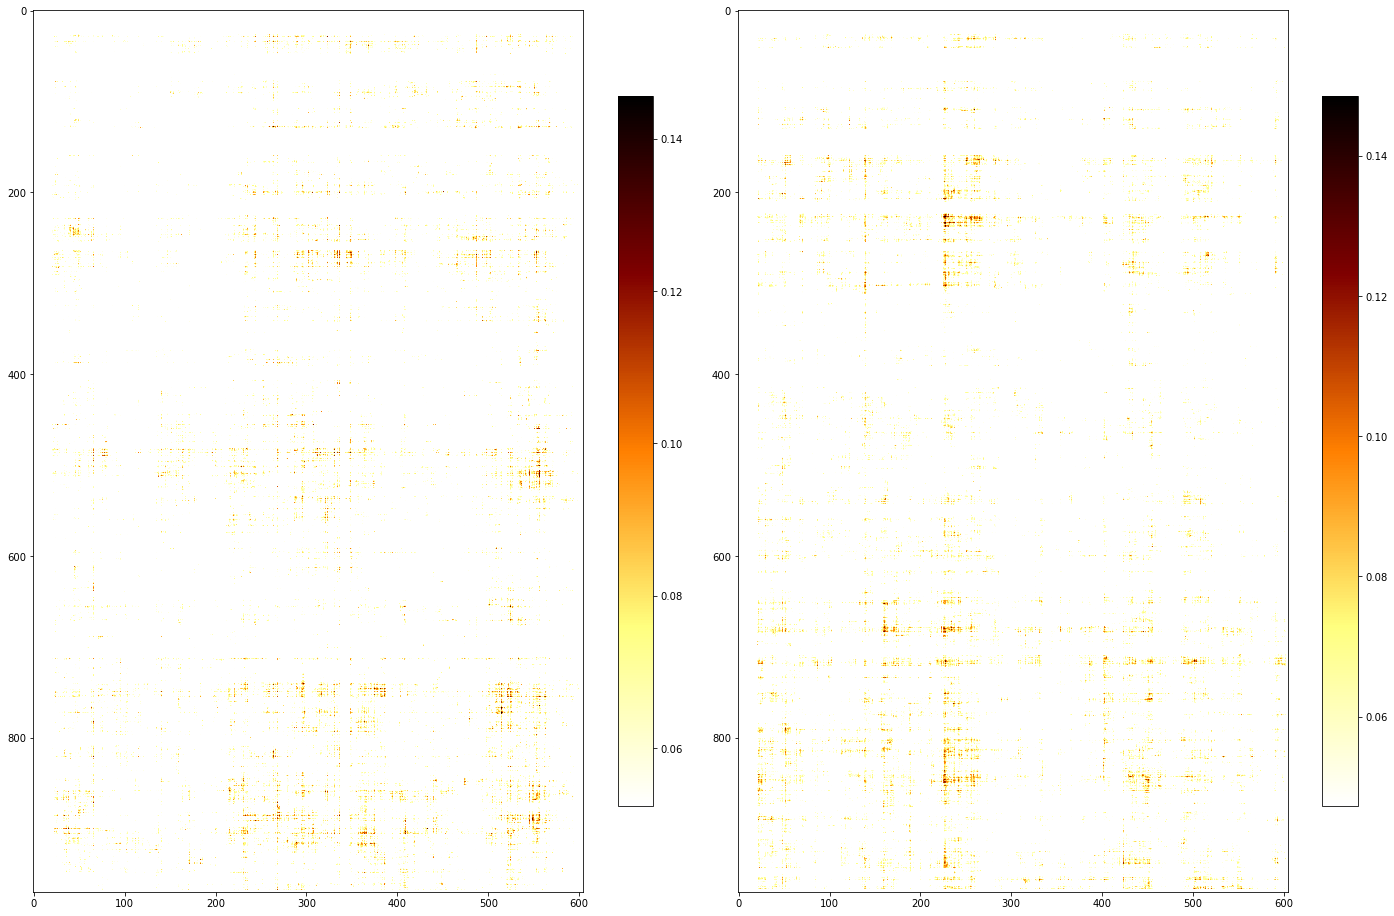

In [20]:
sel_chr = select_chromosomes_coordinates(7, 18, chr_windows_sizes_150kb)

fig, ax = plot_multiple_heatmaps(n_mats = 2, mats = [gw_PI_95_significant_3NP_150kb_dopa[sel_chr[0]:sel_chr[1], sel_chr[2]:sel_chr[3]], gw_PI_95_significant_mesc_3NP_150kb[sel_chr[0]:sel_chr[1], sel_chr[2]:sel_chr[3]]], x_figsize=20, y_figsize=20)

print(spearmanr(gw_PI_3NP_150kb_dopa[sel_chr[0]:sel_chr[1], sel_chr[2]:sel_chr[3]].flatten(), gw_PI_mesc_3NP_150kb[sel_chr[0]:sel_chr[1], sel_chr[2]:sel_chr[3]].flatten() , nan_policy='omit' ))

del fig, ax, sel_chr


# Trans-cis ratio #

In [ ]:
def single_bin_trans_cis(bin_idx,  chr_windows_sizes, matrix, chr):
    start, stop, _, _ = select_chromosomes_coordinates(chr, chr ,chr_windows_sizes)
    trans = np.hstack((matrix[:start, bin_idx], matrix[bin_idx, stop:]))
    cis   = np.hstack((matrix[start:bin_idx, bin_idx], matrix[bin_idx, bin_idx:stop]))
    return np.nanmean(trans)/np.nanmean(cis)

In [ ]:
def gw_trans_cis(chr_windows_sizes, matrix):
    l = []

    for c in range(1,20):
        chr_start, _, _, _ = select_chromosomes_coordinates(c, c , chr_windows_sizes)
        for j in range(chr_windows_sizes[c-1]):
            l.append(single_bin_trans_cis(bin_idx = chr_start + j, chr_windows_sizes = chr_windows_sizes, matrix = matrix, chr = c) )

    return l

In [ ]:
PI_trans_cis_ratios_3NP_150kb_dopa = gw_trans_cis(chr_windows_sizes_150kb, gw_PI_3NP_150kb_dopa)
significant_PI_95_trans_cis_ratios_3NP_150kb_dopa = gw_trans_cis(chr_windows_sizes_150kb, gw_PI_95_significant_3NP_150kb_dopa)

PI_trans_cis_ratios_mesc_3NP_150kb = gw_trans_cis(chr_windows_sizes_150kb, gw_PI_mesc_3NP_150kb)
significant_PI_95_trans_cis_ratios_mesc_3NP_150kb = gw_trans_cis(chr_windows_sizes_150kb, gw_PI_95_significant_mesc_3NP_150kb)

<ipython-input-20-ead1000d3a43>:5: RuntimeWarning: Mean of empty slice
  return np.nanmean(trans)/np.nanmean(cis)
<ipython-input-20-ead1000d3a43>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return np.nanmean(trans)/np.nanmean(cis)


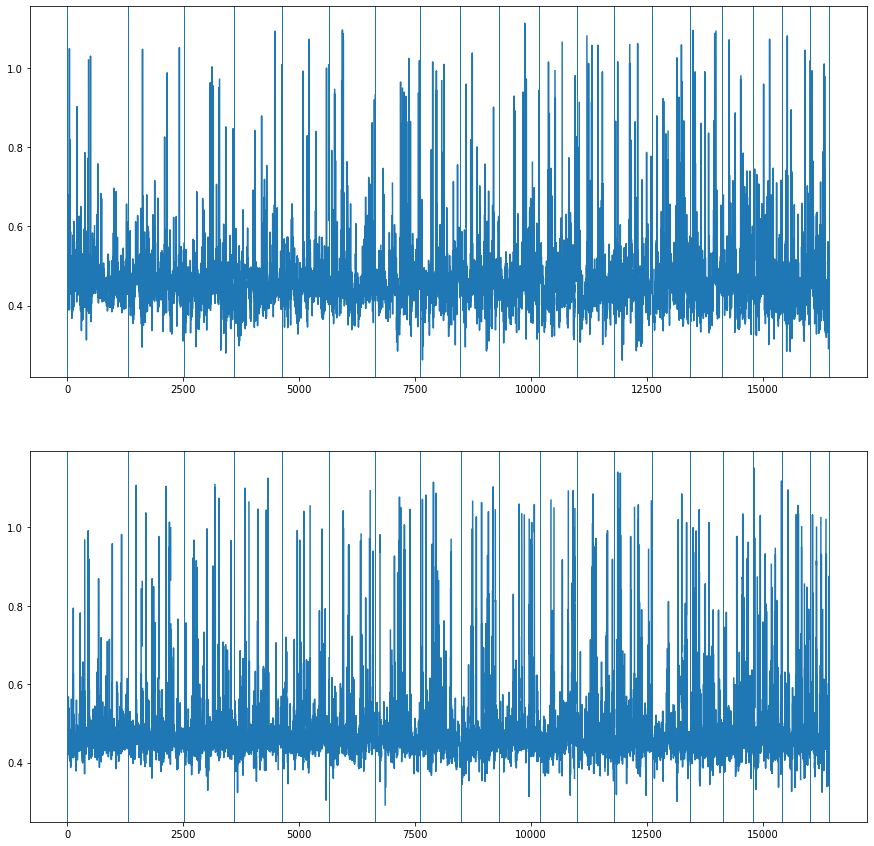

In [ ]:
fig, ax = plt.subplots(2, figsize = (15,15))

ax[0].plot(significant_PI_95_trans_cis_ratios_3NP_150kb_dopa);
ax[1].plot(significant_PI_95_trans_cis_ratios_mesc_3NP_150kb);

ax[0].axvline(0, linewidth = 1);
for i in np.cumsum(chr_windows_sizes_150kb):
    ax[0].axvline(i, linewidth = 1);

ax[1].axvline(0, linewidth = 1);
for i in np.cumsum(chr_windows_sizes_150kb):
    ax[1].axvline(i, linewidth = 1);

del fig, ax

In [ ]:
spearmanr(significant_PI_95_trans_cis_ratios_3NP_150kb_dopa, significant_PI_95_trans_cis_ratios_mesc_3NP_150kb, nan_policy='omit')

SpearmanrResult(correlation=0.11187241880127902, pvalue=2.1996862764718542e-42)